Importaciones

In [12]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

def plot_bar(df, x, y, title, xlabel, ylabel, rotation=45):
    plt.figure()
    df.plot(kind="bar", x=x, y=y, legend=False, rot=rotation)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


In [13]:
def load_one(possible_names):
    # intenta en cwd, ./datasets y /datasets
    for name in possible_names:
        for base in ["", "datasets", "/datasets"]:
            path = os.path.join(base, name) if base else name
            if os.path.isfile(path):
                return pd.read_csv(path, encoding="utf-8-sig"), path
    # búsqueda recursiva como último recurso
    for name in possible_names:
        matches = glob.glob(f"**/{name}", recursive=True)
        if matches:
            return pd.read_csv(matches[0], encoding="utf-8-sig"), matches[0]
    return None, None

df01, p1 = load_one(["project_sql_result_01.csv", "moved_project_sql_result_01.csv"])
df04, p4 = load_one(["project_sql_result_04.csv", "moved_project_sql_result_04.csv"])
df07, p7 = load_one(["project_sql_result_07.csv", "moved_project_sql_result_07.csv"])

if (df01 is None) or (df04 is None) or (df07 is None):
    missing = []
    if df01 is None: missing.append("01")
    if df04 is None: missing.append("04")
    if df07 is None: missing.append("07")
    raise FileNotFoundError(f"No se encontró alguno de los CSV: {', '.join(missing)}. "
                            "Descárgalos y vuelve a ejecutar.")

print("Rutas detectadas:")
print("  df01 ->", p1)
print("  df04 ->", p4)
print("  df07 ->", p7)

# Guardar copias con nombres canónicos en la carpeta actual (para evitar líos después)
df01.to_csv("project_sql_result_01.csv", index=False)
df04.to_csv("project_sql_result_04.csv", index=False)
df07.to_csv("project_sql_result_07.csv", index=False)

display(df01.head())
display(df04.head())
display(df07.head())


Rutas detectadas:
  df01 -> project_sql_result_01.csv
  df04 -> project_sql_result_04.csv
  df07 -> project_sql_result_07.csv


,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


Celda 3 — Tipos de datos (EDA Paso 4)

In [15]:
# Asegurar tipos correctos
df01["company_name"] = df01["company_name"].astype("string")
df01["trips_amount"] = pd.to_numeric(df01["trips_amount"], errors="coerce").astype("Int64")

df04["dropoff_location_name"] = df04["dropoff_location_name"].astype("string")
df04["average_trips"] = pd.to_numeric(df04["average_trips"], errors="coerce")

print(df01.info())
print(df04.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     string
 1   trips_amount  64 non-null     Int64 
dtypes: Int64(1), string(1)
memory usage: 1.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     string 
 1   average_trips          94 non-null     float64
dtypes: float64(1), string(1)
memory usage: 1.6 KB
None


Celda 4 — Top 10 barrios por finalizaciones promedio

In [16]:
top10 = df04.sort_values("average_trips", ascending=False).head(10).reset_index(drop=True)
print("Top 10 barrios por finalizaciones promedio (nov 2017)")
display(top10)


Top 10 barrios por finalizaciones promedio (nov 2017)


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


Celda 5 — Gráfico: viajes por empresa (15–16 nov)

<Figure size 640x480 with 0 Axes>

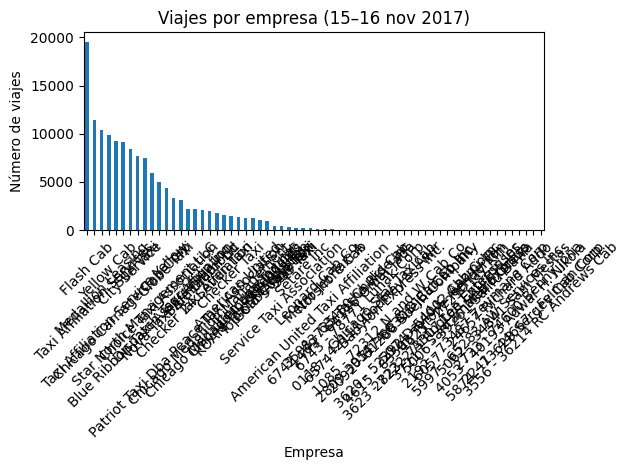

In [17]:
df01_plot = df01.sort_values("trips_amount", ascending=False).reset_index(drop=True)
plot_bar(
    df01_plot,
    x="company_name", y="trips_amount",
    title="Viajes por empresa (15–16 nov 2017)",
    xlabel="Empresa", ylabel="Número de viajes", rotation=45
)


Celda 6 — Gráfico: Top 10 barrios

<Figure size 640x480 with 0 Axes>

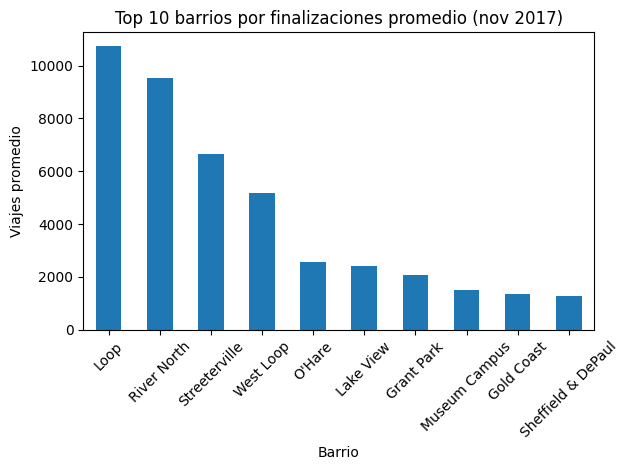

In [18]:
plot_bar(
    top10,
    x="dropoff_location_name", y="average_trips",
    title="Top 10 barrios por finalizaciones promedio (nov 2017)",
    xlabel="Barrio", ylabel="Viajes promedio", rotation=45
)


Prueba de hipótesis (Paso 5)

Celda 7 — Preparación de datos para el test

# Limpieza mínima
df07 = df07.dropna(subset=["weather_conditions", "duration_seconds"]).copy()
df07 = df07[df07["duration_seconds"] > 0].copy()

bad = df07.loc[df07["weather_conditions"] == "Bad", "duration_seconds"].astype(float)
good = df07.loc[df07["weather_conditions"] == "Good", "duration_seconds"].astype(float)

print(f"n_bad={len(bad)}, n_good={len(good)}")
print(f"media_bad={bad.mean():.1f}s, media_good={good.mean():.1f}s")


Celda 8 — Welch t-test (+ opcional Mann–Whitney)

In [20]:
from scipy import stats as st

alpha = 0.05

t_stat, p_val = st.ttest_ind(bad, good, equal_var=False, alternative="two-sided")
print(f"Welch t-test: t={t_stat:.3f}, p={p_val:.6f}")
print("Conclusión:",
      "Rechazamos H0 → La duración promedio cambia en sábados lluviosos."
      if p_val < alpha else
      "No rechazamos H0 → No hay evidencia suficiente de cambio en la duración promedio.")

# Opcional robusto
u_stat, p_val_u = st.mannwhitneyu(bad, good, alternative="two-sided")
print(f"Mann–Whitney U: U={u_stat:.0f}, p={p_val_u:.6f}")


Welch t-test: t=6.979, p=0.000000
Conclusión: Rechazamos H0 → La duración promedio cambia en sábados lluviosos.
Mann–Whitney U: U=107114, p=0.000000


Celda 9 — (Opcional) Levene + tamaño de efecto

In [21]:
from scipy.stats import levene

lev_stat, lev_p = levene(bad, good, center='median')
print(f"Levene: stat={lev_stat:.3f}, p={lev_p:.6f} -> "
      f"{'varianzas iguales' if lev_p>=0.05 else 'varianzas diferentes'}")

def cohens_d(a, b):
    na, nb = len(a), len(b)
    sa2, sb2 = np.var(a, ddof=1), np.var(b, ddof=1)
    s_pooled = np.sqrt(((na-1)*sa2 + (nb-1)*sb2) / (na+nb-2))
    return (np.mean(a) - np.mean(b)) / s_pooled

if len(bad) > 1 and len(good) > 1:
    d = cohens_d(bad, good)
    print(f"Cohen's d: {d:.3f} (≈0.2 pequeño, 0.5 mediano, 0.8 grande)")


Levene: stat=0.183, p=0.668731 -> varianzas iguales
Cohen's d: 0.559 (≈0.2 pequeño, 0.5 mediano, 0.8 grande)


Cómo planteé las hipótesis

Variable de interés (Y): duration_seconds de los viajes Loop → O’Hare que ocurren en sábado.

Factor (X): condiciones climáticas al inicio del viaje, derivadas de weather_records:

Bad si description contiene “rain” o “storm”.

Good en caso contrario.

Grupos comparados: dos grupos independientes (Bad vs Good).

Hipótesis:

H0 (nula): la media de duration_seconds es igual en clima Bad y Good.

𝜇
Bad
=
𝜇
Good
μ
Bad
	​

=μ
Good
	​


H1 (alternativa): la media cambia entre Bad y Good (no especificamos dirección).

𝜇
Bad
≠
𝜇
Good
μ
Bad
	​


=μ
Good
	​

 (prueba de dos colas)

Usamos dos colas porque el enunciado dice “cambia”, sin afirmar si aumenta o disminuye.

Qué criterio usé y por qué

Prueba principal: t-test de Welch para dos muestras independientes (dos colas).

Por qué Welch:

Comparamos medias de una variable continua entre dos grupos independientes → familia de pruebas t.

Welch no asume varianzas iguales y es robusto ante tamaños de muestra distintos → situación típica (suele haber más viajes en “Good” que en “Bad”).

Con tamaños moderados, el CLT ayuda a que la media tenga distribución aproximadamente normal, aun si las duraciones son algo asimétricas.

Chequeos y soporte (opcionales pero recomendables):

Levene para evaluar igualdad de varianzas (informativo, no requisito para Welch).

Mann–Whitney U como prueba no paramétrica de robustez si hay fuerte asimetría/outliers.

Tamaño de efecto (Cohen’s d) para interpretar magnitud práctica, no solo significancia.

Nivel de significación: 
𝛼
=
0.05
α=0.05 (estándar), con decisión:

Si 
𝑝
<
𝛼
p<α → rechazo H0 (evidencia de cambio en la duración promedio).

Si 
𝑝
≥
𝛼
p≥α → no rechazo H0 (no hay evidencia suficiente de cambio).